In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np; np.set_printoptions(linewidth=140)
import pandas as pd; pd.set_option('display.width', 160)
from tqdm import tqdm
import matplotlib.pyplot as plt
import datetime as dt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchinfo


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Command line training.
We provide an example checkpoint. Jump to the inference part.

```bash
# Command line training
python train_schrodinger_bridge.py --problem-name sinusoid --forward-net Unetv2 --backward-net Transformerv2  \
    --train-method alternate_imputation_v2 \
    --DSM-warmup --dsm-train-method dsm_imputation_v2 --num-itr-dsm 3000 --train-bs-x-dsm 80 --train-bs-t-dsm 1 \
    --train-bs-x 12 --train-bs-t 12 --num-stage 15 --num-epoch 2 --num-itr 300 --samp-bs 1600 \
    --sde-type ve --sigma-min 0.001 --sigma-max 15.0 --interval 100 \
    --lr-dsm 5e-4 --lr-f 3e-5 --lr-b 3e-5 --lr-step 300 \
    --num-eval-sample 1 --permute-batch \
    --sinusoid_dataset_path ./data/schrodinger_bridge/sinusoid_dynamic_signal_missratio_0.0_noisestd_0.02.npy \
    --notes 'example' --gpu 1
```

In [ ]:
import argparse
import options
import colored_traceback.always
from ipdb import set_trace as debug

problem_name = 'sinusoid'
opt = options.get_default_args(problem_name)
opt.problem_name = problem_name
timestamp = dt.datetime.now().strftime("%m_%d_%Y_%H%M%S")
opt.sinusoid_dataset_path = './data/schrodinger_bridge/sinusoid_dynamic_signal_missratio_0.0_noisestd_0.02.npy'
opt.forward_net = 'Unetv2'
opt.backward_net = 'Transformerv2'
opt.train_method = 'alternate_imputation'
opt.sde_type = 've'
opt.sigma_max = 15.0
opt.sigma_min = 0.001
opt.interval = 100
opt.train_bs_x_dsm = 80
opt.train_bs_t_dsm = 1
opt.train_bs_x = 12
opt.train_bs_t = 12
opt.lr_dsm = 5e-4
opt.lr = 3e-5
opt.l2_norm = 1e-6
opt.samp_bs = 1600
opt.num_eval_sample = 1
opt.gpu = 1
opt.notes = 'NULL'
opt.dir = f'{problem_name}_{opt.forward_net}_{opt.backward_net}_{opt.sde_type}_alternate_{timestamp}_{opt.notes}'
opt.ckpt_path = 'results/' + opt.dir
opt = options.post_process_args(opt)

print('-'*40, 'forward net quick I/O test', '-'*40)
from models.Unet.Unetv2 import build_unetv2
net_name = 'Unetv2'
net = build_unetv2(opt.model_configs[net_name], True)
x = torch.randn(33, 1, opt.input_size[0], opt.input_size[1])
t = torch.randint(0, opt.interval, size=(33,))
o = net(x, t)
print(o.shape)

print('-'*40, 'backward net quick I/O test', '-'*40)
from models.Transformer.Transformerv2 import build_transformerv2
net_name = 'Transformerv2'
net = build_transformerv2(opt.model_configs[net_name], opt.interval, False)
total_input = torch.randn(33, 2, opt.input_size[0], opt.input_size[1])
cond_mask = torch.randn(33, 1, opt.input_size[0], opt.input_size[1])
t = torch.randint(0, opt.interval, size=(33,))
diff_input = (total_input, cond_mask)
o = net(diff_input, t)
print(o.shape)


In [ ]:
from runner import Runner
run = Runner(opt)
_=torchinfo.summary(run.z_f, depth=2, verbose=1)
_=torchinfo.summary(run.z_b, depth=2, verbose=1)

In [ ]:
opt.DSM_warmup = True
opt.dsm_train_method = 'dsm_imputation_v2' # 'dsm_imputation_v2', 'dsm_imputation', 'csdi'
opt.num_itr_dsm = 3000
opt.num_stage = 15
opt.num_epoch = 2
opt.num_itr = 500
run.sb_alternate_imputation_train(opt)


# Evaluation & unconditinal inference

##### (optional) Restore checkpoints.

In [21]:
import util

ckpt_folder = './results/sinusoid_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_imputation_v2_05_22_2023_093043_ICML_eg/'
ckpt_file = ckpt_folder + 'stage_14_fb.npz'
util.restore_checkpoint(opt, run, ckpt_file)

#loading checkpoint ./results/sinusoid_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_imputation_v2_05_22_2023_093043_/stage_14_fb.npz...
state_dict keys: dict_keys(['z_f', 'optimizer_f', 'ema_f', 'z_b', 'optimizer_b', 'ema_b'])
#successfully loaded all the modules
#loading form ema shadow parameter for polices
#######summary of checkpoint##########


#### Imputation & conditional inference

In [22]:
import dataset_sinusoid
_, _, test_loader = dataset_sinusoid.get_dataloader(opt.sinusoid_dataset_path, eval_length=50, batch_size=10, seed=1)
print('num batches', len(test_loader))
item = next(iter(test_loader))
print(item.keys())
print(item['observed_data'].shape)

Dataset Total obs_vals.shape (10000, 50, 8)
train/test/val num samples 8000 1500 500
num batches 50
dict_keys(['observed_data', 'observed_mask', 'gt_mask', 'timepoints'])
torch.Size([10, 50, 8])


In [23]:
from util import conditional_imputation_eval
import runner

output_dir = ckpt_folder
print('save samples to:', ckpt_folder)
conditional_imputation_eval('imputation', opt, test_loader, run, num_samples=100, num_eval_batches=1, output_dir=output_dir)

save samples to: ./results/sinusoid_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_imputation_v2_05_22_2023_093043_/
100%|█████████████████████████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]
total number of eval points: 1600.0
RMSE: 0.06560753635374816
MAE: 0.04524166584014892
CRPS: 0.07413544152912341
saved samples: ./results/sinusoid_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_imputation_v2_05_22_2023_093043_//generated_100_samples_05_22_2023_114221.pk
saved metrics: ./results/sinusoid_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_imputation_v2_05_22_2023_093043_//metrics_05_22_2023_114221.json


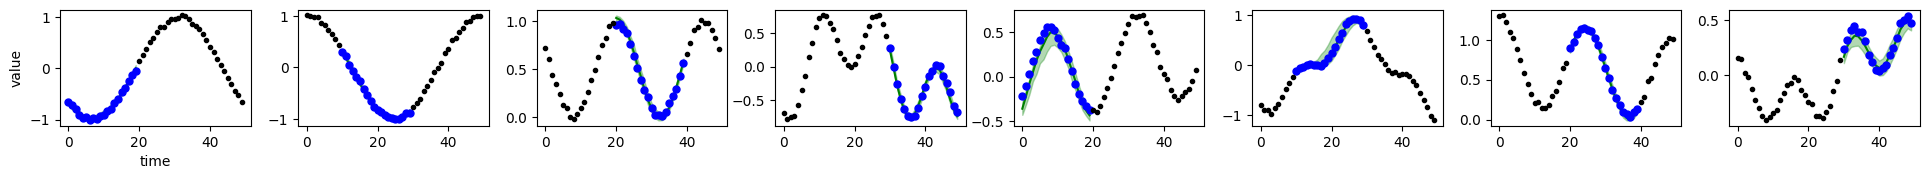

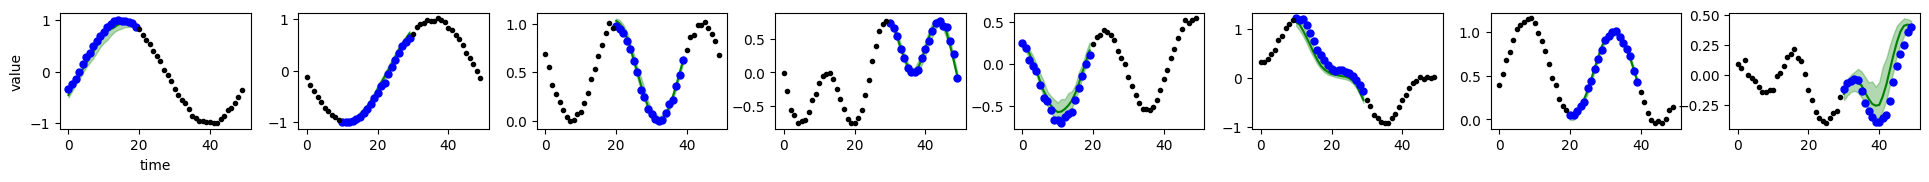

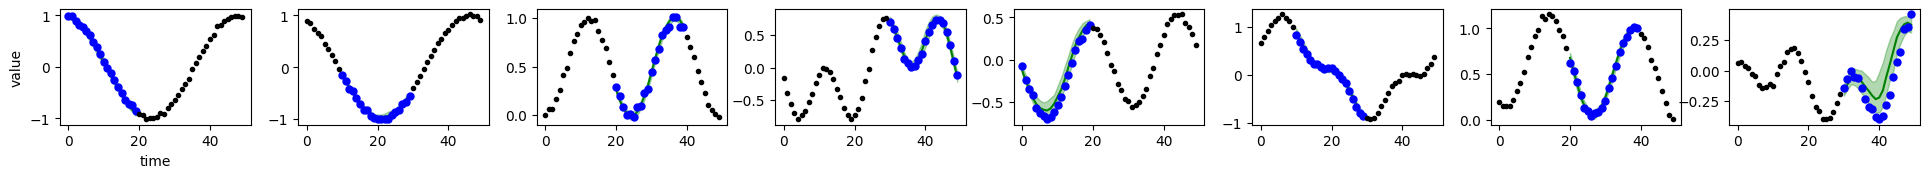

In [25]:
import util
file_path = './results/sinusoid_Unetv2_Transformerv2_ve_alternate_imputation_v2_dsm_imputation_v2_05_22_2023_093043_ICML_eg/generated_100_samples_05_22_2023_114221.pk'
util.plot_saved_imputation_samples(file_path, dataind=1)
util.plot_saved_imputation_samples(file_path, dataind=3)
util.plot_saved_imputation_samples(file_path, dataind=6)